In [1]:
import scipy.io
from pyedflib import highlevel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import groupby
import csv
import pickle

# Label data

## Combine EEGs with doctors' annotations

### Variables and loading data

In [7]:
# Variables to define
sampling_rate = 256

In [8]:
# Load annotation file
annt = scipy.io.loadmat('../raw_data/annotations_2017.mat')

### Functions to label

In [9]:
# Format the EEG 
def eeg_formated(signals, names_ele):
    data_signals = signals.T # transpose the signals from datapoints
    data_signals = pd.DataFrame(data_signals) # create a pandas dataframe
    
    data_signals.columns = names_ele # rename columns
    
    return data_signals

In [10]:
# Format the annotations
def diagnosis(n):
    patient_A=annt["annotat_new"][0][n-1][0]
    patient_B=annt["annotat_new"][0][n-1][1]
    patient_C=annt["annotat_new"][0][n-1][2]
    
    #converting seconds to datapoints

    patient_A=patient_A.tolist()
    patient_B=patient_B.tolist()
    patient_C=patient_C.tolist()
    
    patient_A_dtp=[]
    patient_B_dtp=[]
    patient_C_dtp=[]  
    for elem in patient_A:
        for i in range(sampling_rate):
            patient_A_dtp.append(elem) 
    for elem in patient_B:
        for i in range(sampling_rate):
            patient_B_dtp.append(elem)
        
    for elem in patient_C:
        for i in range(sampling_rate):
            patient_C_dtp.append(elem)
            
    target_=pd.DataFrame({"Diagnosis A":patient_A_dtp,"Diagnosis B":patient_B_dtp,"Diagnosis C":patient_C_dtp})
    
    return target_  

### Create a dictionnary of dataframes

In [11]:
# Create a dictionnary of dataframe

patients_numbers = list(range(1, 80))

patient_with_issue = [4, 29, 50] # Can't import ECG4, ECG29 and ECG50

for i in patient_with_issue:
    patients_numbers.remove(i)
    

d = {}
for i in patients_numbers:
    signals_i, signal_headers_i, header_i = highlevel.read_edf(f"../raw_data/eeg{i}.edf")
    
    names_ele_i = [signal_headers_i[iele]['label'] for iele in range(signals_i.shape[0])] # extract electrode names
    
    eeg_patient_i = eeg_formated(signals_i, names_ele_i) # format the ECG
    diagnosis_patient_i = diagnosis(i) # format the diagnosis
    
    data_patient_i = pd.merge(left=eeg_patient_i, right=diagnosis_patient_i, how='left', left_index=True, right_index=True) # merge ecg and diagnosis

    d[i] = data_patient_i # create a dictionnary of dataframes

In [34]:
# Example patient 5
d[25].columns

Index(['EEG Fp1-REF', 'EEG Fp2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
       'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
       'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
       'EEG T6-REF', 'EEG Fz-REF', 'EEG Cz-REF', 'EEG Pz-REF', 'ECG EKG-REF',
       'Resp Effort-REF', 'Diagnosis A', 'Diagnosis B', 'Diagnosis C'],
      dtype='object')

## Add a time column with the seconds

In [ ]:
def add_time(df):
    list_time=[]
    for i in range(len(df)):
        list_time.append(i//sampling_rate)
    df["time"]=list_time
    return df

In [ ]:
# Loop for all patients
for i in d.keys():
    add_time(d[i])

In [ ]:
# Example patient 5
d[5]

## Create targets variables "is_seizure_{letter}" when seizure lasts at least 10 seconds

In [ ]:
def is_seizure(df):
    
    threshold = sampling_rate*10
    
    df['is_seizure_A'] = df["Diagnosis A"].groupby((df["Diagnosis A"] != df["Diagnosis A"].shift()).cumsum()).transform('size') * df["Diagnosis A"]
    df['is_seizure_A'] = (df['is_seizure_A'] > threshold).astype(int)
    
    df['is_seizure_B'] = df["Diagnosis B"].groupby((df["Diagnosis B"] != df["Diagnosis B"].shift()).cumsum()).transform('size') * df["Diagnosis B"]
    df['is_seizure_B'] = (df['is_seizure_B'] > threshold).astype(int)
    
    df['is_seizure_C'] = df["Diagnosis C"].groupby((df["Diagnosis C"] != df["Diagnosis C"].shift()).cumsum()).transform('size') * df["Diagnosis C"]
    df['is_seizure_C'] = (df['is_seizure_C'] > threshold).astype(int)
    
    return df 

In [ ]:
# Loop for all patients
for i in d.keys():
    is_seizure(d[i])

In [ ]:
# Example patient 5
d[5]

## Create the final target variable

**Target variable** = *is_seizure_target*
- equals 1 when at least 2 doctors detected a seizure at that datapoint
- equels 0 else

In [ ]:
def create_target(df):
    df['is_seizure_target'] = np.where(df['is_seizure_A'] + df['is_seizure_B'] + df['is_seizure_C'] >= 2, 1, 0)
    return df

In [ ]:
# Loop for all patients
for i in d.keys():
    create_target(d[i])

In [ ]:
# Example patient 5
d[5]

In [ ]:
# Export for patient 5
d[5].to_csv("../data_formated/data_patient_5.csv")

## Create and export final dictionnary

In [ ]:
def remove_useless_columns(df):
    df.drop(columns=['Diagnosis A', 'Diagnosis B', 'Diagnosis C'], inplace=True)
    return df

In [ ]:
# Loop for all patients
for i in d.keys():
    remove_useless_columns(d[i])

In [ ]:
# Example patient 5
d[5]

In [ ]:
# Export dictionnary of dataframes
        
with open('../data_formated/dictionnary_formated.pickle', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Appendix - Scenarios regarding the target variable

Create 3 targets ('scenario_1', 'scenario_2', 'scenario_3'):
- 1. seizure if at least one doctor said it's a seizure
- 2. seizure if at least two doctors saif it's a seizure
- 3. seizure by consensus (the three doctors)

def create_scenarios_target(df):
    df['scenario_1'] = np.where(df['is_seizure_A'] + df['is_seizure_B'] + df['is_seizure_C'] >= 1, 1, 0)
    df['scenario_2'] = np.where(df['is_seizure_A'] + df['is_seizure_B'] + df['is_seizure_C'] >= 2, 1, 0)
    df['scenario_3'] = np.where(df['is_seizure_A'] + df['is_seizure_B'] + df['is_seizure_C'] >= 3, 1, 0)

create_scenarios_target(d[5])
d[5]

for i in d.keys():
    create_scenarios_target(d[i])

def number_of_electrodes(df):
    number_elec = df.shape[1]-10
    return number_elec

def duration_recording(df):
    duration_seconds = len(df)/sampling_rate
    duration_minutes = duration_seconds/60
    return duration_seconds, duration_minutes

def total_duration_of_seizures(df,column):
    total_duration_seizures_ = sum(df[column])/sampling_rate
    return total_duration_seizures_

def duration_each_seizure(df,column):
    is_seizure_=list(df[column])
   
    dur_list_=[]
    
    list_=[sum(g) for i, g in groupby(is_seizure_) if i == 1]
   
    for elem in list_:
        dur_list_.append(elem/sampling_rate)
 
    return dur_list_
    
def number_total_seizures(df,column):
    is_seizure_=list(df[column])
   
    list_=[sum(g) for i, g in groupby(is_seizure_) if i == 1]
  
    return len(list_)

- different scenarios for diagnosis 
- inspect EDA

def exploratory_scenarios(df, n):
    features = ['number_of_electrodes', 'duration__recording_seconds', 'duration__recording_minutes', \
                'total_duration_seizures_1', 'total_duration_seizures_2', 'total_duration_seizures_3', \
                'duration_each_seizure_1', 'duration_each_seizure_2', 'duration_each_seizure_3', \
                'number_total_seizures_1', 'number_total_seizures_2', 'number_total_seizures_3']
    results = [number_of_electrodes(df), duration_recording(df)[0], duration_recording(df)[1], \
               total_duration_of_seizures(df, 'scenario_1'), total_duration_of_seizures(df, 'scenario_2'), total_duration_of_seizures(df, 'scenario_3'), \
               duration_each_seizure(df, 'scenario_1'), duration_each_seizure(df, 'scenario_2'), duration_each_seizure(df, 'scenario_3'), \
               number_total_seizures(df, 'scenario_1'), number_total_seizures(df, 'scenario_2'), number_total_seizures(df, 'scenario_3')]

    dic = {'Features':features,f'Results_{n}': results}
    data = pd.DataFrame(dic)
    
    return data

exploratory_scenarios(d[5], 5)

***Comments***: 
- In case of scenario 3, the three doctors predict a seizure but not exactly at the same time. One same seizure can be counted multiple times
- We agree to keep the **scenario 2: at least 2 doctors out of 3 to consider it as a seizure**

# Exploratory Data Analysis

- number of electrodes
- duration of each recording
- number of seizures (if there are any)
- duration of seizures
- ...

## Import data

In [2]:
# Import dictionnary of dataframes

with open('../data_formated/dictionnary_formated.pickle', 'rb') as handle:
    d = pickle.load(handle)

In [3]:
d[5]

,EEG Fp1-Ref,EEG Fp2-Ref,EEG F7-Ref,EEG F3-Ref,EEG Fz-Ref,EEG F4-Ref,EEG F8-Ref,EEG T3-Ref,EEG C3-Ref,EEG Cz-Ref,...,EEG T6-Ref,EEG O1-Ref,EEG O2-Ref,ECG EKG,Resp Effort,time,is_seizure_A,is_seizure_B,is_seizure_C,is_seizure_target
0,-1.217202,18.161445,26.858948,13.736399,0.308676,-8.694003,20.145086,8.395827,-16.018216,10.684644,...,15.262277,-16.781155,-8.846591,8.853591,0.308676,0,1,1,1,1
1,-3.048255,42.270313,54.629922,22.586490,0.308676,-16.628567,40.744435,20.908025,-32.192520,20.297674,...,30.978818,-31.124405,-15.560453,21.365788,1.681965,0,1,1,1,1
2,-8.236240,42.575488,49.594526,10.837232,-1.217202,-11.745758,37.845267,19.687322,-29.293352,18.008857,...,30.215879,-26.089009,-10.525056,12.057934,3.970782,0,1,1,1,1
3,-3.506019,35.251275,51.578167,19.839910,-1.827553,-12.966461,40.286672,19.229559,-32.650283,18.466620,...,32.199520,-28.072650,-11.593171,1.224202,4.275958,0,1,1,1,1
4,3.360431,31.894344,49.747113,19.076971,-2.743080,-13.881987,36.624565,9.158766,-31.429581,17.551094,...,30.978818,-27.920062,-12.050934,5.344072,4.275958,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983291,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,...,0.003500,0.003500,0.003500,0.003500,0.003500,3840,0,0,1,0
983292,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,...,0.003500,0.003500,0.003500,0.613851,0.003500,3840,0,0,1,0
983293,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,...,0.003500,0.003500,0.003500,0.766439,0.003500,3840,0,0,1,0
983294,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,0.003500,...,0.003500,0.003500,0.003500,-0.759439,0.003500,3840,0,0,1,0


## Functions for EDA

In [ ]:
def number_of_electrodes(df):
    number_elec = df.shape[1]-5
    return number_elec

def duration_recording(df):
    duration_seconds = len(df)/sampling_rate
    duration_minutes = duration_seconds/60
    return duration_seconds, duration_minutes

def total_duration_of_seizures(df,column):
    total_duration_seizures_ = sum(df[column])/sampling_rate
    return total_duration_seizures_

def duration_each_seizure(df,column):
    is_seizure_=list(df[column])
    dur_list_=[]
    list_=[sum(g) for i, g in groupby(is_seizure_) if i == 1]
    for elem in list_:
        dur_list_.append(elem/sampling_rate)
    return dur_list_
    
def time_of_seizure(df,column):
    list_of_time=[]
    start_seizure=[]
    end_seizure=[]
    start_seizure_seconds=[]
    end_seizure_seconds=[]
    if df[column][0]==1:
        list_of_time.append(0)
    for i in range(len(df)-1):    
        if df[column][i]!=df[column][i+1]:
            list_of_time.append(i+1)
    for j in range(len(list_of_time)):
        if j%2==0:
            start_seizure.append(list_of_time[j])
            start_seizure_seconds.append(list_of_time[j]//sampling_rate)
        else:
            end_seizure.append(list_of_time[j])
            end_seizure_seconds.append(list_of_time[j]//sampling_rate)
    return start_seizure,start_seizure_seconds, end_seizure, end_seizure_seconds
    
def number_total_seizures(df,column):
    is_seizure_=list(df[column])
    list_=[sum(g) for i, g in groupby(is_seizure_) if i == 1]
    return len(list_)

In [ ]:
def exploratory_analysis(df, n):
    features = ['number_of_electrodes', 'duration_recording_seconds', 'duration__recording_minutes', \
                'total_duration_seizures_A', 'total_duration_seizures_B', 'total_duration_seizures_C', 'total_duration_seizures_target',\
                'duration_each_seizure_A', 'duration_each_seizure_B', 'duration_each_seizure_C', 'duration_each_seizure_target', \
                'start_seizure_seizure_A', 'start_seizure_seizure_B', 'start_seizure_seizure_C', 'start_seizure_seizure_target', \
                'start_seizure_seconds_A', 'start_seizure_seconds_B', 'start_seizure_seconds_C', 'start_seizure_seconds_target', \
                'end_seizure_A', 'end_seizure_B', 'end_seizure_C', 'end_seizure_target', \
                'end_seizure_seconds_A', 'end_seizure_seconds_B', 'end_seizure_seconds_C', 'end_seizure_seconds_target', \
                'number_total_seizures_A', 'number_total_seizures_B', 'number_total_seizures_C', 'number_total_seizures_target']
    results = [number_of_electrodes(df), duration_recording(df)[0], duration_recording(df)[1], \
               total_duration_of_seizures(df, 'is_seizure_A'), total_duration_of_seizures(df, 'is_seizure_B'), total_duration_of_seizures(df, 'is_seizure_C'), total_duration_of_seizures(df, 'is_seizure_target'),\
               duration_each_seizure(df, 'is_seizure_A'), duration_each_seizure(df, 'is_seizure_B'), duration_each_seizure(df, 'is_seizure_C'), duration_each_seizure(df, 'is_seizure_target'),\
               time_of_seizure(df, 'is_seizure_A')[0], time_of_seizure(df, 'is_seizure_B')[0], time_of_seizure(df, 'is_seizure_C')[0], time_of_seizure(df, 'is_seizure_target')[0],\
               time_of_seizure(df, 'is_seizure_A')[1], time_of_seizure(df, 'is_seizure_B')[1], time_of_seizure(df, 'is_seizure_C')[1], time_of_seizure(df, 'is_seizure_target')[1],\
               time_of_seizure(df, 'is_seizure_A')[2], time_of_seizure(df, 'is_seizure_B')[2], time_of_seizure(df, 'is_seizure_C')[2], time_of_seizure(df, 'is_seizure_target')[2],\
               time_of_seizure(df, 'is_seizure_A')[3], time_of_seizure(df, 'is_seizure_B')[3], time_of_seizure(df, 'is_seizure_C')[3], time_of_seizure(df, 'is_seizure_target')[3],\
               number_total_seizures(df, 'is_seizure_A'), number_total_seizures(df, 'is_seizure_B'), number_total_seizures(df, 'is_seizure_C'), number_total_seizures(df, 'is_seizure_target')]

    dic = {'Features':features,f'Results_{n}': results}
    data = pd.DataFrame(dic)
    
    return data

In [ ]:
# Example patient 5
exploratory_analysis(d[5], 5)

## Full exploratory dataset

In [ ]:
# -- DO NOT RUN THIS CELL : IMPORT CSV FILE -- 
#patients = list(d.keys())[1:]

#exploratory_data = exploratory_analysis(d[1], 1)

#for i in patients:
#    exploratory_data[f'Results_{i}'] = exploratory_analysis(d[i], i)[f'Results_{i}']
    
#exploratory_data.set_index('Features', inplace=True)    
#exploratory_data

In [ ]:
# -- DO NOT RUN THIS CELL : IMPORT CSV FILE -- 
#exploratory_data_transposed = exploratory_data.T
#exploratory_data_transposed

In [ ]:
#exploratory_data.to_csv("../data_formated/data_exploratory.csv")
#exploratory_data_transposed.to_csv("../data_formated/data_exploratory_transposed.csv")

In [2]:
# -- RUN THIS CELL -- 
exploratory_data = pd.read_csv("../data_label/data_exploratory.csv", index_col=[0])
exploratory_data_transposed = pd.read_csv("../data_label/data_exploratory_transposed.csv", index_col=[0])

In [3]:
exploratory_data.head()
exploratory_data_transposed.head()

,number_of_electrodes,duration_recording_seconds,duration__recording_minutes,total_duration_seizures_A,total_duration_seizures_B,total_duration_seizures_C,total_duration_seizures_target,duration_each_seizure_A,duration_each_seizure_B,duration_each_seizure_C,...,end_seizure_C,end_seizure_target,end_seizure_seconds_A,end_seizure_seconds_B,end_seizure_seconds_C,end_seizure_seconds_target,number_total_seizures_A,number_total_seizures_B,number_total_seizures_C,number_total_seizures_target
Results_1,21,6993.0,116.550000,1602.0,3123.0,953.0,1518.0,"[18.0, 135.0, 59.0, 29.0, 31.0, 49.0, 57.0, 23...","[17.0, 27.0, 17.0, 158.0, 36.0, 57.0, 26.0, 50...","[26.0, 120.0, 16.0, 19.0, 105.0, 16.0, 12.0, 1...",...,"[30976, 114688, 182272, 199168, 284160, 305664...","[30976, 114688, 203776, 251392, 308736, 420352...","[121, 451, 800, 982, 1209, 1642, 1707, 2871, 3...","[49, 122, 277, 447, 582, 796, 939, 999, 1206, ...","[121, 448, 712, 778, 1110, 1194, 1612, 1634, 2...","[121, 448, 796, 982, 1206, 1642, 1703, 2871, 3...",25,40,31,26
Results_2,21,3761.0,62.683333,65.0,0.0,0.0,0.0,"[47.0, 18.0]",[],[],...,[],[],"[1975, 2076]",[],[],[],2,0,0,0
Results_3,21,4412.0,73.533333,0.0,0.0,0.0,0.0,[],[],[],...,[],[],[],[],[],[],0,0,0,0
Results_5,21,3841.0,64.016667,3325.0,3189.0,3184.0,3213.0,"[127.0, 631.0, 534.0, 853.0, 1180.0]","[107.0, 621.0, 454.0, 825.0, 1182.0]","[147.0, 620.0, 457.0, 571.0, 245.0, 419.0, 725.0]",...,"[37632, 225024, 370944, 576768, 641536, 788736]","[32512, 225280, 370944, 641536, 982784]","[127, 887, 1508, 2532, 3838]","[107, 880, 1446, 2504, 3839]","[147, 879, 1449, 2253, 2506, 3081]","[127, 880, 1449, 2506, 3839]",5,5,7,5
Results_6,21,4703.0,78.383333,0.0,0.0,491.0,0.0,[],[],"[16.0, 98.0, 69.0, 308.0]",...,"[576000, 606720, 651008, 733184]",[],[],[],"[2250, 2370, 2543, 2864]",[],0,0,4,0


In [24]:
df = pd.DataFrame(exploratory_data.iloc[30, :])
df.iloc[8]

number_total_seizures_target    0
Name: Results_10, dtype: object

In [ ]:
# 4 healthy patients : 2, 3, 6, 10
# 6 unhealthy patients : 1, 13, 14, 18, 19, 78

## Visualization

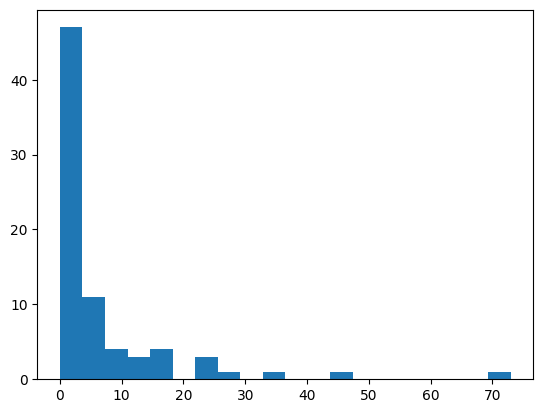

In [6]:
# Total number of seizures
plt.hist(exploratory_data_transposed['number_total_seizures_target'], bins=20);

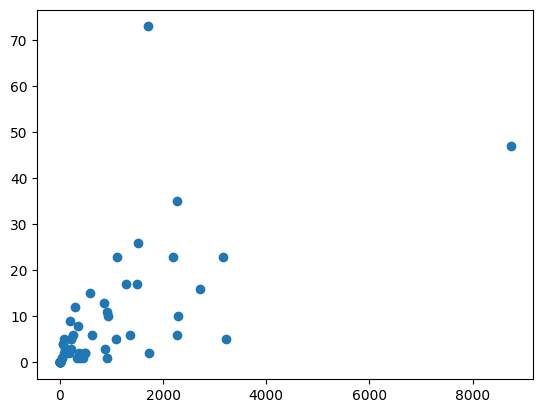

In [8]:
# Total duration of seizures vs total number of seizures
plt.scatter(exploratory_data_transposed['total_duration_seizures_target'], exploratory_data_transposed['number_total_seizures_target'])